### Information Driven Bar Sampling

Information Driven Bar Sampling의 목적은 시장에 새로운 정보가 도달할 경우 더 빈번히 표본을 추출하기 위한 것이다. 여기서 '정보'라는 것은 시장 미시구조 측면에서 사용된다. 나중에 살펴보겠지만, 미시 구조 이론은 불균형한 부호의 거래량이 지속되는 데 주안점을 두고 있는데, 이 현상은 정보 기반 거래자의 존재 여부와 연계돼 있기 때문이다. 표본 추출을 정보기반 거래자의 도착과 연동시키면 가격이 새로운 균형 상태에 이르기 전에 투자 의사결정을 내릴 수 있게 된다. 이번 절에서는 각종 정보 도달 지표를 사용해 어떻게 바를 샘플링하는지 알아본다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from FinancialMachineLearning.barsampling.core import *

In [2]:
data = pd.read_parquet('../../Data/IVEfuture.parquet')

In [3]:
data.index = pd.to_datetime(data['date'])

In [4]:
bar = ImbalanceBarFeatures(data)

#### 1. Tick imbalance bar

Tick의 시퀀스 $\{(p_t, \nu_t)\}_{t = 1, \dots, T}$가 있다고 가정해 보자. 여기서 $p_t$는 틱 $t$에 연계된 가격이고, $\nu_t$는 틱 $t$에서의 거래량이다. 이른바 틱 규칙은 다음을 만족하는 $\{b_t\}_{t = 1, \dots, T}$를 정의한다.

$$
b_t=
\begin{cases}
b_{t-1} & \text{ if } \Delta p_t = 0 \\
\frac{\vert \Delta p_t\vert}{\Delta p_t} & \text{ if } \Delta p_t \neq 0 
\end{cases}
$$

여기서 $b_t \in \{-1, 1\}$이고 경계 조건 $b_0$은 바로 직전 바에서의 끝단값 $b_t$와 일치하도록 설정한다. Tick Imbalance Bar의 기본 아이디어는 틱 불균형이 예상을 초과할 때마다 표본 추출한다는 것이다. 여기서는 부호가 있는 틱의 누적값이 주어진 임계값을 넘는 틱 인덱스 값 $T$를 찾고자 한다. 이제 $T$를 결정하는 절차에 대해 알아보자. 

첫째, 시간 $T$에서의 틱 불균형에 대해 다음과 같이 정의한다.

$$
\theta_T = \sum_{t = 1}^T b_t
$$

둘째, 바의 시작점에서의 기대값 $\theta_T$를 다음처럼 계산한다. $E_0[\theta_T] = E_0[T](P[b_t = 1] - P[b_t = -1])$, 여기서 $E_0[T]$는 틱 바의 기대 크기이고, $P[b_t = 1]$은 틱이 매수로 분류될 비조건부 확률이다. 그리고 $P[b_t = -1]$은 틱이 매도로 분류될 비조건부 확률이다. $P[b_t = 1] + P[b_t = -1] = 1$이므로 $E_0[\theta_T] = E_0[T](2P[b_t = 1] - 1)$이다. 실제로 $E_0[T]$는 이전 바들로부터의 $T$ 값의 지수 가중 이동 평균으로 계산할 수 있고, $(2P[b_t = 1] - 1)$은 이전 바들로부터의 $b_t$값의 지수 가중 이동평균으로 계산할 수 있다.

셋째, Tick Imbalance Bar를 다음 조건을 만족하는 틱의 $T^*$-contigous 부분 집합으로 정의한다.

$$T^* {\arg\min}_T \left\{ 
\vert \theta_T \vert \geq E_0[T] \vert 2P[b_t = 1] -1
\right\}$$

여기서 기대 불균형의 크기는 $|2P[b_t = 1] - 1|$로 추정된다. $\theta_T$가 예상보다 더 불균형일 경우 작은 $T$가 이러한 조건을 만족할 것이다. 이에 따라 Tick Imbalance Bar들은 정보 기반 거래자가 있을 경우 더 빈번히 발생한다. 사실 Tick Imbalance Bar를 동일한 정보를 가진 거래의 버킷으로 이해할 수 있다.

In [5]:
tick_imbalance,_ = bar.const_tick_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 300
)
tick_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 10:00:15,300,50.790,51.2100,50.7100,51.210,91860,62641,300,4.691140e+06
1,09/28/2009 10:02:50,353,51.210,51.2600,51.2000,51.250,11654,9454,53,5.971518e+05
2,09/28/2009 10:14:15,482,51.250,51.2900,51.1900,51.260,53622,41292,129,2.748684e+06
3,09/28/2009 11:14:34,938,51.258,51.3800,51.1873,51.340,121780,65149,456,6.246861e+06
4,09/28/2009 11:51:21,1197,51.340,51.4360,51.3000,51.420,88672,49587,259,4.554167e+06
...,...,...,...,...,...,...,...,...,...,...
10415,03/27/2024 15:24:54,11287664,184.890,185.2600,184.6700,185.260,182865,95256,1061,3.381943e+07
10416,03/27/2024 15:34:07,11287836,185.260,185.4800,185.2300,185.460,31380,15427,172,5.816297e+06
10417,03/28/2024 14:16:12,11289813,185.460,186.9100,185.4201,186.870,399430,177280,1977,7.449272e+07
10418,03/28/2024 15:14:56,11290272,186.870,187.0200,186.6950,187.005,103685,54913,459,1.937218e+07


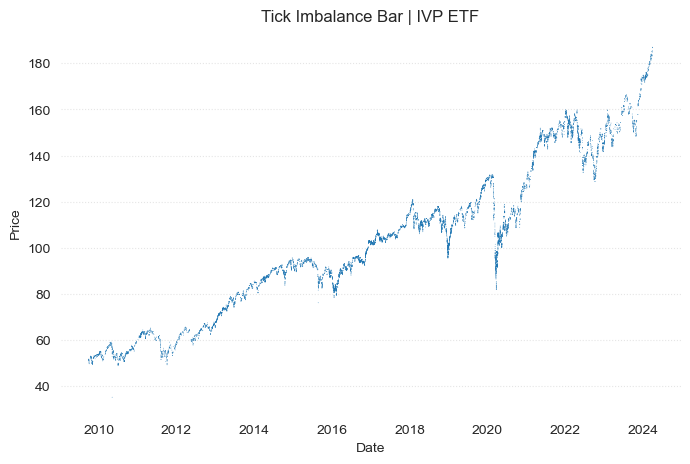

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(tick_imbalance['date_time']), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVP ETF')
plt.show()

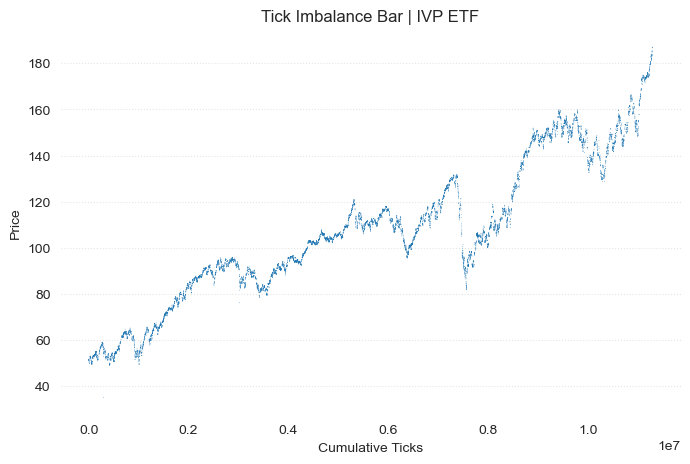

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tick_imbalance['cum_ticks'].cumsum(), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Ticks')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVP ETF')
plt.show()

#### 2. Volume imbalance bar

In [8]:
volume_imbalance, _ = bar.const_volume_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 50
)
volume_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:42:17,50,50.7900,50.8500,50.7100,50.8500,10344,5564,50,5.254412e+05
1,09/28/2009 09:44:09,55,50.8300,50.9100,50.8300,50.9100,1900,1600,5,9.668200e+04
2,09/28/2009 09:44:24,61,50.9100,50.9300,50.9100,50.9300,2400,2400,6,1.222060e+05
3,09/28/2009 09:46:35,83,51.0000,51.0700,51.0000,51.0700,11600,9900,22,5.923320e+05
4,09/28/2009 09:53:49,157,51.0700,51.1500,51.0500,51.1400,22975,18325,74,1.174163e+06
...,...,...,...,...,...,...,...,...,...,...
641525,01/25/2024 15:53:02,11177392,174.2100,174.2200,174.2100,174.2200,40941,40641,4,7.132738e+06
641526,01/25/2024 15:59:28,11178002,174.2000,174.4500,174.1800,174.4100,172712,79312,610,3.011464e+07
641527,01/25/2024 16:00:00,11178077,174.4100,174.5100,174.4100,174.5100,41313,36373,75,7.208924e+06
641528,01/25/2024 16:03:27,11178078,173.8239,173.8239,173.8239,173.8239,5000000,0,1,8.691195e+08


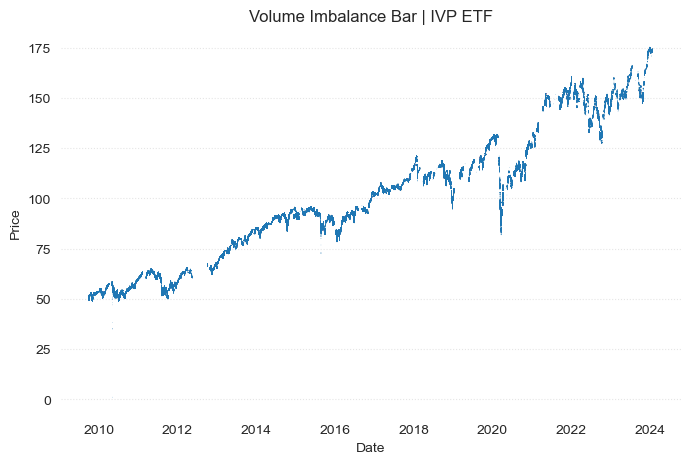

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(volume_imbalance['date_time']), 
    volume_imbalance.close,
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVP ETF')
plt.show()

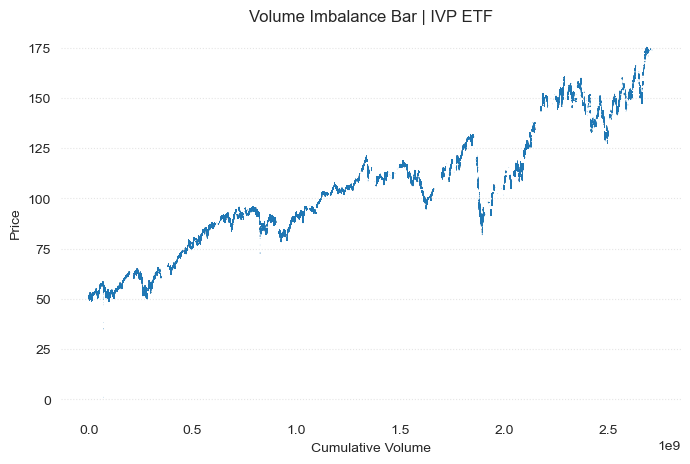

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    volume_imbalance['volume'].cumsum(), 
    volume_imbalance['close'],
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5,
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVP ETF')
plt.show()

#### 3. Dollar imbalance bar

In [11]:
dollar_imbalance,_ = bar.const_dollar_imbalance_bar(
    expected_imbalance_window = 252, 
    exp_num_ticks_init = 63
)
dollar_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:46:35,81,50.7900,51.0700,50.7100,51.0700,22044,15264,81,1.122167e+06
1,09/28/2009 09:47:38,109,51.0700,51.0700,51.0500,51.0700,10500,10400,28,5.361760e+05
2,09/28/2009 09:54:43,230,51.0700,51.1500,51.0700,51.1400,43932,29782,121,2.246275e+06
3,09/28/2009 10:02:52,358,51.1400,51.2600,51.0800,51.2500,35138,24749,128,1.798798e+06
4,09/28/2009 10:13:45,471,51.2500,51.2900,51.1900,51.2600,35214,22884,113,1.805171e+06
...,...,...,...,...,...,...,...,...,...,...
226688,01/25/2024 11:52:43,11160471,173.9400,174.0500,173.2001,173.5500,2314128,1565502,2846,4.014564e+08
226689,01/25/2024 12:47:47,11161710,173.5300,173.5643,173.2300,173.3000,1038164,754623,1239,1.799505e+08
226690,01/25/2024 13:04:09,11161965,173.2780,173.6500,173.2400,173.6100,1808227,1732214,255,3.138784e+08
226691,01/25/2024 16:03:27,11178078,173.6000,174.5100,173.5000,173.8239,9170250,1760848,16113,1.594306e+09


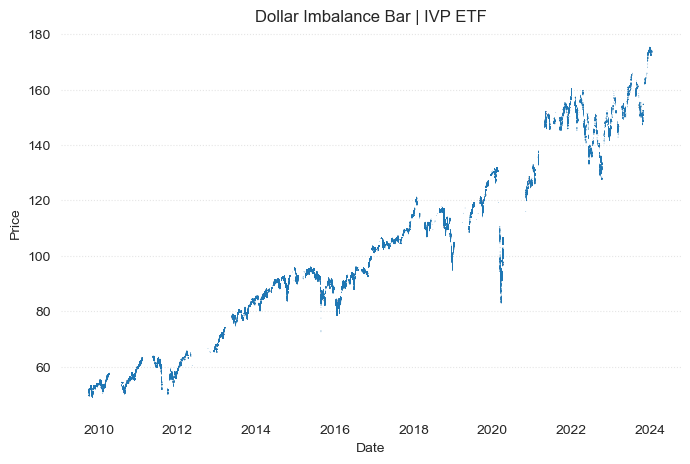

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(dollar_imbalance['date_time']), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVP ETF')
plt.show()

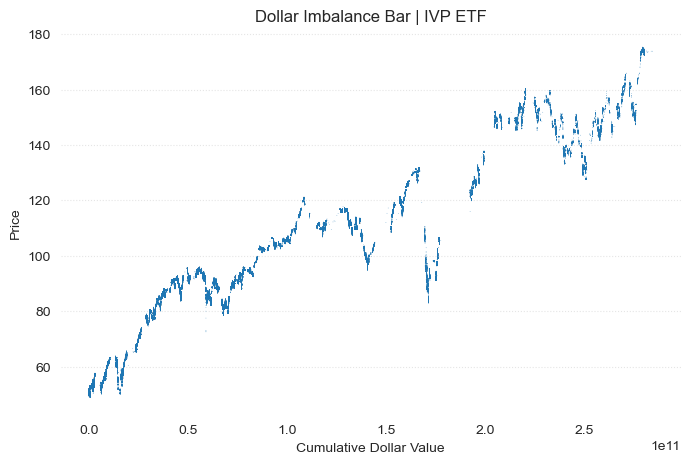

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar_imbalance['cum_dollar_value'].cumsum(), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Dollar Value')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVP ETF')
plt.show()

In [18]:
tib_returns = tick_imbalance.close.pct_change().dropna()
vib_returns = volume_imbalance.close.pct_change().dropna()
dib_returns = dollar_imbalance.close.pct_change().dropna()

tib_returns.index = pd.to_datetime(tick_imbalance.date_time[1:])
vib_returns.index = pd.to_datetime(volume_imbalance.date_time[1:])
dib_returns.index = pd.to_datetime(dollar_imbalance.date_time[1:])

In [19]:
tib_standard = (tib_returns - tib_returns.mean())/tib_returns.std()
vib_standard = (vib_returns - vib_returns.mean())/vib_returns.std()
dib_standard = (dib_returns - dib_returns.mean())/dib_returns.std()

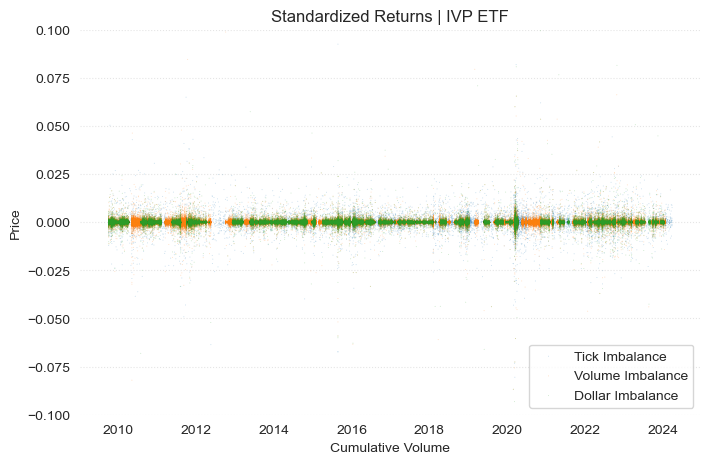

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tib_returns.index, 
    tib_returns, 
    s = 2, 
    marker = '.',
    label = 'Tick Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    vib_returns.index,
    vib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Volume Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    dib_returns.index, 
    dib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Dollar Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.ylim([-0.1, 0.1])
plt.legend()
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Standardized Returns | IVP ETF')
plt.show()

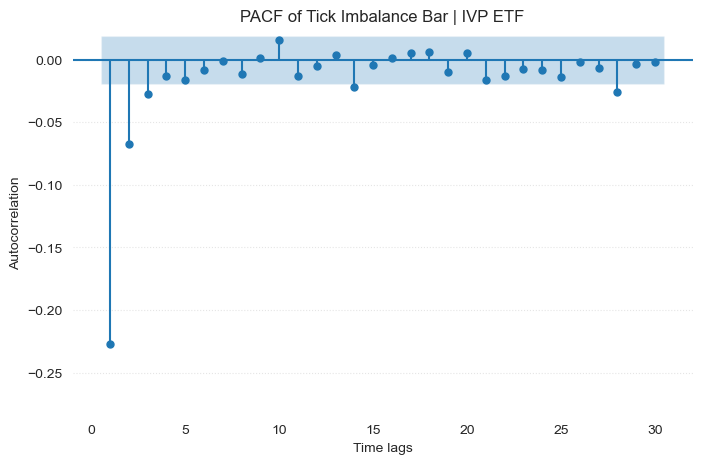

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Tick Imbalance Bar | IVP ETF')
plt.show()

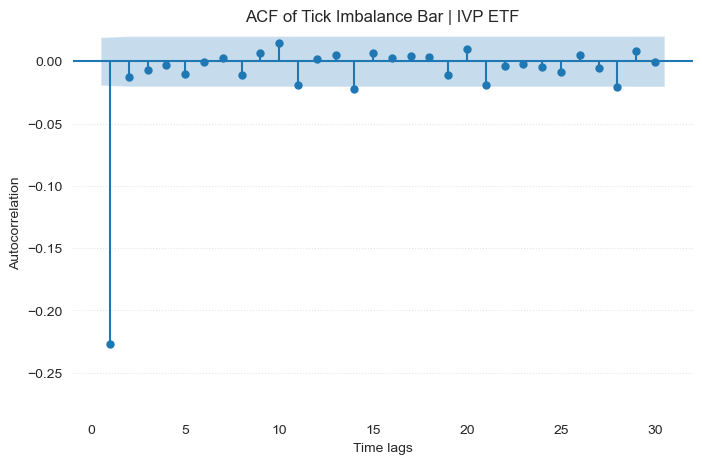

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Tick Imbalance Bar | IVP ETF')
plt.show()

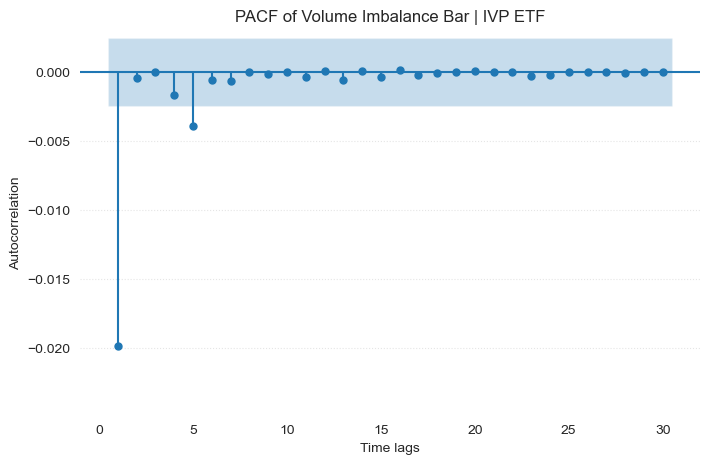

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Volume Imbalance Bar | IVP ETF')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Volume Imbalance Bar | IVP ETF')
plt.show()

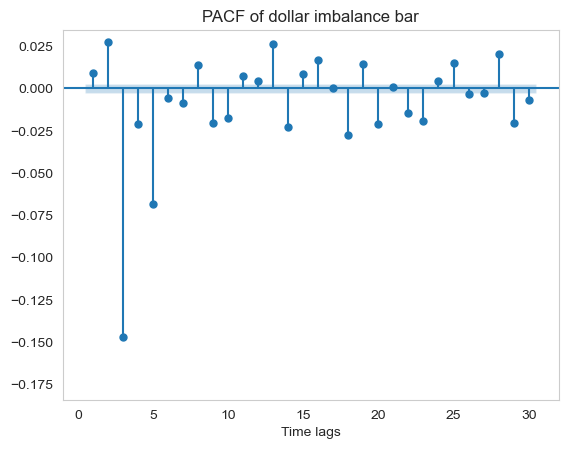

In [24]:
plot_pacf(dollar_imbalance['close'].pct_change().dropna(), auto_ylims = True, lags = range(1, 31))
plt.xlabel('Time lags', fontsize = 10)
plt.title('PACF of dollar imbalance bar')
plt.grid(False)
plt.show()

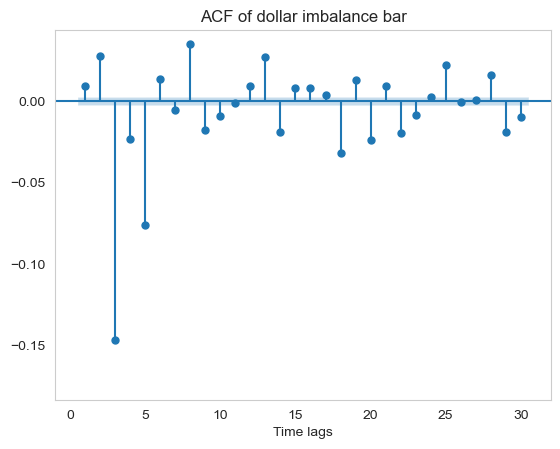

In [25]:
plot_acf(
    dollar_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, lags = range(1, 31)
)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of dollar imbalance bar')
plt.show()

In [26]:
time_bar = pd.read_parquet('../../Data/IVEfuture.parquet')

In [27]:
time_bar.index = pd.to_datetime(time_bar['date'])

In [54]:
time_30 = time_bar.resample('30min').last()

In [55]:
time_30 = time_30['price'].dropna().pct_change().dropna()

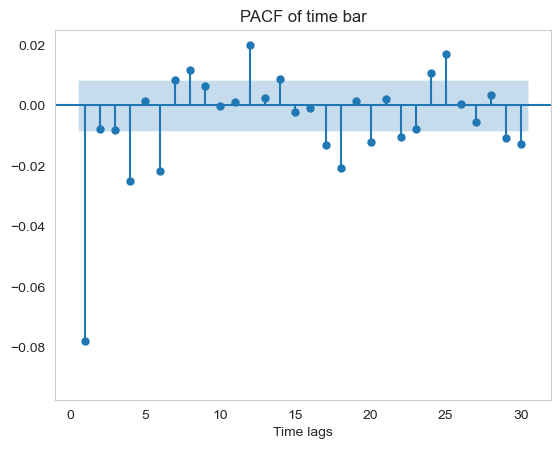

In [56]:
plot_pacf(time_30, auto_ylims = True, lags = range(1, 31))
plt.xlabel('Time lags', fontsize = 10)
plt.title('PACF of time bar')
plt.grid(False)
plt.show()

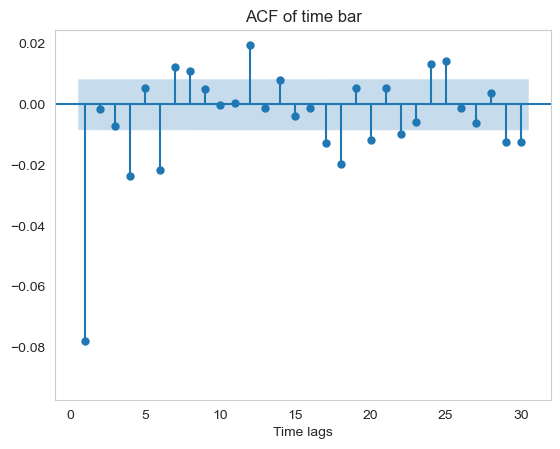

In [57]:
plot_acf(
    time_30, 
    auto_ylims = True, lags = range(1, 31)
)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of time bar')
plt.show()